In [ ]:
import pandas as pd
import torch
from torch import nn
from torchvision.models import resnet18

from torch.utils.checkpoint import checkpoint_sequential
from matplotlib import pyplot as plt

In [ ]:
def _get_gpu_mem(synchronize=True, empty_cache=True):
    return torch.cuda.memory_allocated(), torch.cuda.memory_cached()


def _generate_mem_hook(handle_ref, mem, idx, hook_type, exp):
    def hook(self, *args):
        if len(mem) == 0 or mem[-1]["exp"] != exp:
            call_idx = 0
        else:
            call_idx = mem[-1]["call_idx"] + 1

        mem_all, mem_cached = _get_gpu_mem()
        torch.cuda.synchronize()
        mem.append({
            'layer_idx': idx,
            'call_idx': call_idx,
            'layer_type': type(self).__name__,
            'exp': exp,
            'hook_type': hook_type,
            'mem_all': mem_all,
            'mem_cached': mem_cached,
        })

    return hook


def _add_memory_hooks(idx, mod, mem_log, exp, hr):
    h = mod.register_forward_pre_hook(_generate_mem_hook(hr, mem_log, idx, 'pre', exp))
    hr.append(h)

    h = mod.register_forward_hook(_generate_mem_hook(hr, mem_log, idx, 'fwd', exp))
    hr.append(h)

    h = mod.register_backward_hook(_generate_mem_hook(hr, mem_log, idx, 'bwd', exp))
    hr.append(h)

def log_mem_no_cp(model, inp, mem_log=None, exp=None):
    mem_log = mem_log or []
    exp = exp or f'exp_{len(mem_log)}'
    hr = []
    for idx, module in enumerate(model.modules()):
        _add_memory_hooks(idx, module, mem_log, exp, hr)

    try:
        out = model(inp)
        loss = out.sum()
        loss.backward()
    finally:
        [h.remove() for h in hr]

        return mem_log

def log_mem_no_cp_no_backward(model, inp, mem_log=None, exp=None):
    mem_log = mem_log or []
    exp = exp or f'exp_{len(mem_log)}'
    hr = []
    for idx, module in enumerate(model.modules()):
        _add_memory_hooks(idx, module, mem_log, exp, hr)

    try:
        out = model(inp)
        loss = out.sum()
        #loss.backward()
    finally:
        [h.remove() for h in hr]

        return mem_log

def log_mem_no_cp_no_backward_no_grad(model, inp, mem_log=None, exp=None):
    mem_log = mem_log or []
    exp = exp or f'exp_{len(mem_log)}'
    hr = []
    for idx, module in enumerate(model.modules()):
        _add_memory_hooks(idx, module, mem_log, exp, hr)

    try:
        with torch.no_grad():
          out = model(inp)
          loss = out.sum()
        #loss.backward()
    finally:
        [h.remove() for h in hr]

        return mem_log

def log_mem_cp(model, inp, mem_log=None, exp=None, cp_chunks=3):
    mem_log = mem_log or []
    exp = exp or f'exp_{len(mem_log)}'
    hr = []
    for idx, module in enumerate(model.modules()):
        _add_memory_hooks(idx, module, mem_log, exp, hr)

    try:
        out = checkpoint_sequential(model, cp_chunks, inp)
        loss = out.sum()
        loss.backward()
    finally:
        [h.remove() for h in hr]

        return mem_log


In [ ]:
def plot_mem(
        df,
        exps=None,
        normalize_call_idx=False,
        normalize_mem_all=False,
        filter_fwd=False,
        return_df=False,
        output_file=None
):
    if exps is None:
        exps = df.exp.drop_duplicates()

    fig, ax = plt.subplots(figsize=(10, 5))
    for exp in exps:
        df_ = df[df.exp == exp]

        if normalize_call_idx:
            df_.call_idx = df_.call_idx / df_.call_idx.max()

        if normalize_mem_all:
            df_.mem_all = df_.mem_all - df_[df_.call_idx == df_.call_idx.min()].mem_all.iloc[0]
            df_.mem_all = df_.mem_all // 2 ** 20

        if filter_fwd:
            layer_idx = 0
            callidx_stop = df_[(df_["layer_idx"] == layer_idx) & (df_["hook_type"] == "fwd")]["call_idx"].iloc[0]
            df_ = df_[df_["call_idx"] <= callidx_stop]
            # df_ = df_[df_.call_idx < df_[df_.layer_idx=='bwd'].call_idx.min()]

        plot = df_.plot(ax=ax, x='call_idx', y='mem_all', label=exp)
        if output_file:
            plot.get_figure().savefig(output_file)

    if return_df:
        return df_

In [ ]:
base_dir = '.'
# %% Analysis baseline
bs = 128
input = torch.rand(bs, 3, 224, 224).cuda()

mem_log = []

model = resnet18().cuda()
class Flatten(nn.Module):
    def forward(self, x):
        return torch.flatten(x, 1)

In [ ]:
seq_model = nn.Sequential(
    model.conv1,
    model.bn1,
    model.relu,
    model.maxpool,
    model.layer1,
    model.layer2,
    model.layer3,
    model.layer4,
    model.avgpool,
    Flatten(),
    model.fc,
)

In [ ]:
mem_log.extend(log_mem_no_cp(seq_model, input, exp='no_checkpoints (forward and backward, yes grad)'))

torch.cuda.synchronize()
torch.cuda.empty_cache()

/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:386: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [ ]:
seq_model = nn.Sequential(
    model.conv1,
    model.bn1,
    model.relu,
    model.maxpool,
    model.layer1,
    model.layer2,
    model.layer3,
    model.layer4,
    model.avgpool,
    Flatten(),
    model.fc,
)
mem_log.extend(log_mem_no_cp_no_backward_no_grad(seq_model, input, exp='no_checkpoints (forward only, no grad)'))
torch.cuda.synchronize()
torch.cuda.empty_cache()

/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:386: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


In [ ]:
seq_model = nn.Sequential(
    model.conv1,
    model.bn1,
    model.relu,
    model.maxpool,
    model.layer1,
    model.layer2,
    model.layer3,
    model.layer4,
    model.avgpool,
    Flatten(),
    model.fc,
)

In [ ]:
mem_log.extend(log_mem_no_cp_no_backward(seq_model, input, exp='no_checkpoints (forward only, yes grad)'))
torch.cuda.synchronize()
torch.cuda.empty_cache()

/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:386: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [ ]:
seq_model = nn.Sequential(
    model.conv1,
    model.bn1,
    model.relu,
    model.maxpool,
    model.layer1,
    model.layer2,
    model.layer3,
    model.layer4,
    model.avgpool,
    Flatten(),
    model.fc,
)

In [ ]:
mem_log.extend(log_mem_cp(seq_model, input, cp_chunks=3, exp='3_checkpoints (forward and backward, yes grad)'))

torch.cuda.synchronize()
torch.cuda.empty_cache()

/usr/local/lib/python3.7/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:386: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [ ]:
seq_model = nn.Sequential(
    model.conv1,
    model.bn1,
    model.relu,
    model.maxpool,
    model.layer1,
    model.layer2,
    model.layer3,
    model.layer4,
    model.avgpool,
    Flatten(),
    model.fc,
)

In [ ]:
df = pd.DataFrame(mem_log)

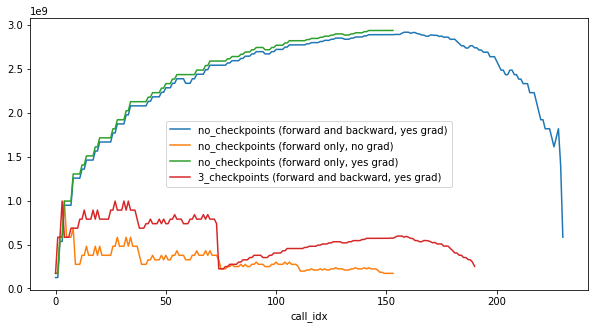

In [ ]:
plot_mem(df)

In [ ]:
df.groupby('exp').mem_all.max().sort_values(ascending=False)/1e-9

exp
no_checkpoints (forward only, yes grad)            2.934686e+18
no_checkpoints (forward and backward, yes grad)    2.914439e+18
3_checkpoints (forward and backward, yes grad)     9.940050e+17
no_checkpoints (forward only, no grad)             9.940050e+17
Name: mem_all, dtype: float64